# Planejamento da Solução

## Input

1. Problema de negócio
 - Selecionar os clientes mais valiosos para criar um programa de fidelidade
2. Conjunto de dados
 - Vendas de e-commerce no período de um ano

## Output

1. <b>Indicação das pessoas que farão parte do programa de fidelidade
    - Tabela com: <br>
            |customerid | is_insider| 
            |    1      |     yes   | 
            |    2      |     no    | 
 
2. <b>Responder as perguntas de negócio:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior valor?
    - Faturamento:
        - Alto Ticket médio
        - Alto LTV
        - Baixa recência (compra mais frequentemente)
        - Alto basket size (tamanho de cesta)
        - Baixa probabilidade de churn (periodo que passa e não vai mais comprar)
        - Alta previsão de LTV
        - Alta propensão de compra
    - Custo:
        - Baixa taxa de devolução
    - Experiência de compra:
        - Alta média das avaliações
        
        
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo Insiders
    
    
3. Quais as principais características desses clientes ?
    - Escrever características do cliente (podem ser utilizadas para busca clientes semelhantes)
        - Idade
        - Localização
    - Escrever caacterísticas do consumo
        - Atributos da clusterização
        
        
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
    
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise de Cohort (como um grupo de pessoas se comporta ao longo do tempo)
        - Sabendo que pessoas que compram calça na primeira compram geram maior faturamento futuro, posso otimizar campanhas
        - Pessoas da localidade X trazem maior faturamento 
    

6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a perodicidade (1 mes, 3 meses)
    - A pessoa precisa ser similar com uma pessoa do grupo
    

7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a perodicidade (1 mes, 3 meses)
    - A pessoa precisa ser não parecida com uma pessoa do grupo (começa a se distanciar do cluster)


8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frete
    - Visita a empresa


# 0.0. IMPORTS

In [172]:
import pandas as pd
import seaborn as sns

import plotly.express as px

from matplotlib import pyplot as plt
from IPython.display import HTML

In [173]:
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import metrics as m

## 0.1. Helper Functions

In [174]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.rcParams['font.size'] = 24
    
    display(HTML ('<style>.container { width:95% !important; } </style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows=30
    pd.set_option('display.expand_frame_repr', False)
       
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [175]:
data_raw = pd.read_csv('../datasets/Ecommerce.csv',encoding='latin-1')
data_raw.drop(columns=['Unnamed: 8'], inplace=True)

# 1.0. PASSO 01 - DATA DESCRIPTION

In [176]:
df1 = data_raw.copy()
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1. Rename Columns

In [177]:
df1.columns = df1.columns.to_series().str.lower()

## 1.2. Data Dimensions

In [178]:
print(f'Counting {df1.shape[0]} rows and {df1.shape[1]} columns')

Counting 541909 rows and 8 columns


## 1.3. Data Types

In [179]:
df1.dtypes

invoiceno       object
stockcode       object
description     object
quantity         int64
invoicedate     object
unitprice      float64
customerid     float64
country         object
dtype: object

## 1.4. Check NA

In [180]:
df1.isna().sum()

invoiceno           0
stockcode           0
description      1454
quantity            0
invoicedate         0
unitprice           0
customerid     135080
country             0
dtype: int64

## 1.5. Fillout NA's

In [181]:
# first cicle --> remove NA's
print(f'Removing {df1.shape[0] - df1.dropna().shape[0]} rows')
df1 = df1.dropna()

print(f'Remain: {df1.shape[0]} rows')

Removing 135080 rows
Remain: 406829 rows


## 1.6. Verifying Types

In [182]:
# invoice date
df1['invoicedate'] = pd.to_datetime(df1['invoicedate'], format='%d-%b-%y')

# customerid 
df1['customerid'] = df1['customerid'].astype('int64')

df1.dtypes

invoiceno              object
stockcode              object
description            object
quantity                int64
invoicedate    datetime64[ns]
unitprice             float64
customerid              int64
country                object
dtype: object

## 1.7. Descriptive Statistics

In [183]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [184]:
df_num_attibutes = num_attributes.describe()

df_num_attibutes.loc['kurtosis',] = num_attributes.describe().kurtosis().values
df_num_attibutes.loc['skew'] = num_attributes.describe().skew().values

df_num_attibutes = df_num_attibutes.T

df_num_attibutes['range'] = df_num_attibutes['max'] - df_num_attibutes['min']

df_num_attibutes = df_num_attibutes[['min', 'max', 'range', 'mean' , '50%', 'std', 
                  'skew', 'kurtosis']].reset_index().rename(columns={'index': 'attribute', '50%': 'median'})

df_num_attibutes

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693370,2.370745,6.140757
1,unitprice,0.0,38970.0,38970.0,3.460471,1.95,69.315162,2.779201,7.776348
2,customerid,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.600303,2.820824,7.968443


#### 1.7.1. Numerical Attributes - Looking for errors

1. Quantity negativo --> Pode ser devolução

2. Unitprice igual a 0 --> promoção? 

In [185]:
# quantity < 0 --> Pode ser devolução

# unitprice == 0 --> promoção? 

### 1.7.1. Categorical Attributes

In [186]:
cat_attributes.head()

,invoiceno,stockcode,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [187]:
# invoice no
letter_index_invoice = cat_attributes['invoiceno'].apply(lambda x: True if re.search('[A-Za-z]',x) != None else False)
print(f"{len(cat_attributes.loc[letter_index_invoice, 'invoiceno'].unique())} unique invoiceno with letters --> probably returns, exchanges")

3654 unique invoiceno with letters --> probably returns, exchanges


In [188]:
# stock code
letter_index_stock = cat_attributes['stockcode'].apply(lambda x: True if re.search('[A-Za-z]',x) != None else False)
print(f"{len(cat_attributes.loc[letter_index_stock, 'stockcode'].unique())} unique stockcode with letters")

886 unique stockcode with letters


In [189]:
cat_attributes['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [190]:
cat_attributes['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

# 2.0. PASSO 02 - FILTRAGEM DE VARIÁVEIS

In [191]:
df2 = df1.copy()

In [192]:
# unitprice
df2 = df2.loc[df2['unitprice'] > 0.01, :]

# stock code != ['POST', 'D', 'M', 'DOT', 'CRUK']
df2 = df2[~df2['stockcode'].isin(['POST', 'D', 'M', 'DOT', 'CRUK'])]

# description

# quantity
df_purchases = df2.loc[df2['quantity'] > 0]
df_returns = df2.loc[df2['quantity'] < 0]

In [193]:
df2

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2017-12-07,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2017-12-07,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2017-12-07,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2017-12-07,4.15,12680,France


# 3.0. PASSO 03 - FEATURE ENGINEERING

In [194]:
df3 = df2.copy()

## 3.1. Mapa Mental de Hipoteses

## 3.2. Criacao das Hipoteses

### 2.1.1. Hipoteses Loja

### 2.1.2. Hipoteses Produto

### 2.1.3. Hipoteses Tempo

## 3.3. Lista final de hipoteses
--> Selecionando as hipoteses que posso validar com os dados nesse momento

## 3.4. Feature Engineering

In [195]:
# creating a reference dataframe --> only id's
df_reference = df2[['customerid']].drop_duplicates(ignore_index=True)

# Revenue --> Faturamento --> Quantity * Price
df2['revenue'] = df2['quantity'] * df2['unitprice']
revenue_per_client = df2[['customerid', 'revenue']].groupby('customerid').sum()
df_reference = df_reference.merge(revenue_per_client, on='customerid')

# Recency --> Today - Last day purchase
last_buy_date_per_client = df_purchases[['customerid', 'invoicedate']].groupby('customerid').max().reset_index()
df_reference = df_reference.merge(last_buy_date_per_client, on='customerid').rename(columns={'invoicedate': 'recency'})
df_reference['recency'] = (df_purchases['invoicedate'].max() - df_reference['recency']).dt.days



# Frequency
helper_group = df_purchases[['customerid', 'invoiceno', 'quantity']].groupby(['customerid', 'invoiceno']).count().reset_index()
frequency_per_client = helper_group[['customerid', 'quantity']].groupby('customerid').count().reset_index()
df_reference = df_reference.merge(frequency_per_client, on='customerid').rename(columns={'quantity': 'frequency'})


# Frequency
helper_group = df_returns[['customerid', 'invoiceno', 'quantity']].groupby(['customerid', 'invoiceno']).count().reset_index()
return_per_client = helper_group[['customerid', 'quantity']].groupby('customerid').count().reset_index()
df_reference = df_reference.merge(return_per_client, on='customerid').rename(columns={'quantity': 'returns'})


# Avg ticket
df_reference['avg_ticket'] = df_reference['revenue'] / df_reference['frequency']

df_reference.head()

,customerid,revenue,recency,frequency,returns,avg_ticket
0,17850,5288.63,372,34,1,155.547941
1,13047,3089.10,56,9,7,343.233333
2,12583,6629.34,2,15,2,441.956000
3,15100,635.10,333,3,3,211.700000
4,15291,4551.51,25,14,5,325.107857


# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [196]:
df4 = df_reference.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

### 4.1.2. Numerical Variable

### 4.1.3. Categorical Variable

## 4.2. Analise Bivariada

### 4.2.1. Resumo das Hipoteses

## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

### 4.3.2. Categorical Attributes

# 5.0. PASSO 05 - PREPARAÇAO DOS DADOS

In [171]:
df5 = df4.copy()

## 5.1. Normalizacao

## 5.2. Scaling

## 5.3. Transformacao

### 5.3.1. Encoding

### 5.3.2. Response Variable Transformation

### 5.3.3. Nature Transformation

# 6.0. PASSO 06 - FEATURE SELECTION

In [197]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test

## 6.2. Feature Selection

# 7.0. PASSO 07 - FINDING THE NUMBER OF CLUSTERS

HYPERPARAMETER FINE TUNING

In [198]:
df7 = df6.copy()

In [199]:
X = df7.drop(columns=['customerid'])

In [200]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1. Within-Cluste Sum of Square (WSS)

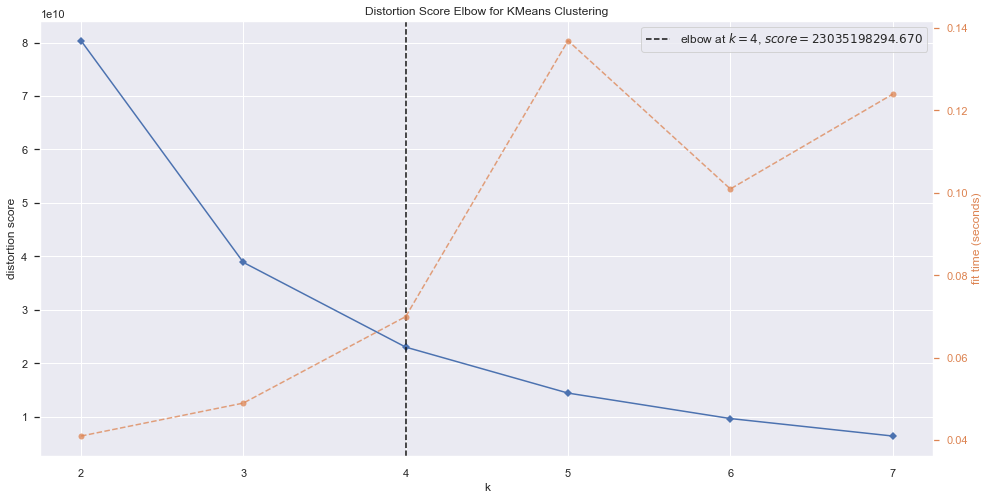

In [201]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timing=False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Score (SS)

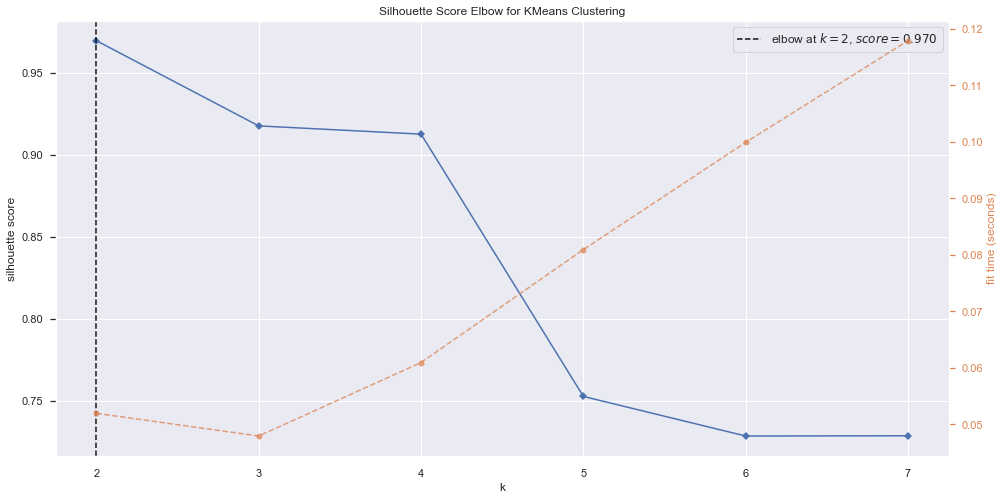

In [202]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette',timing=False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Analysis

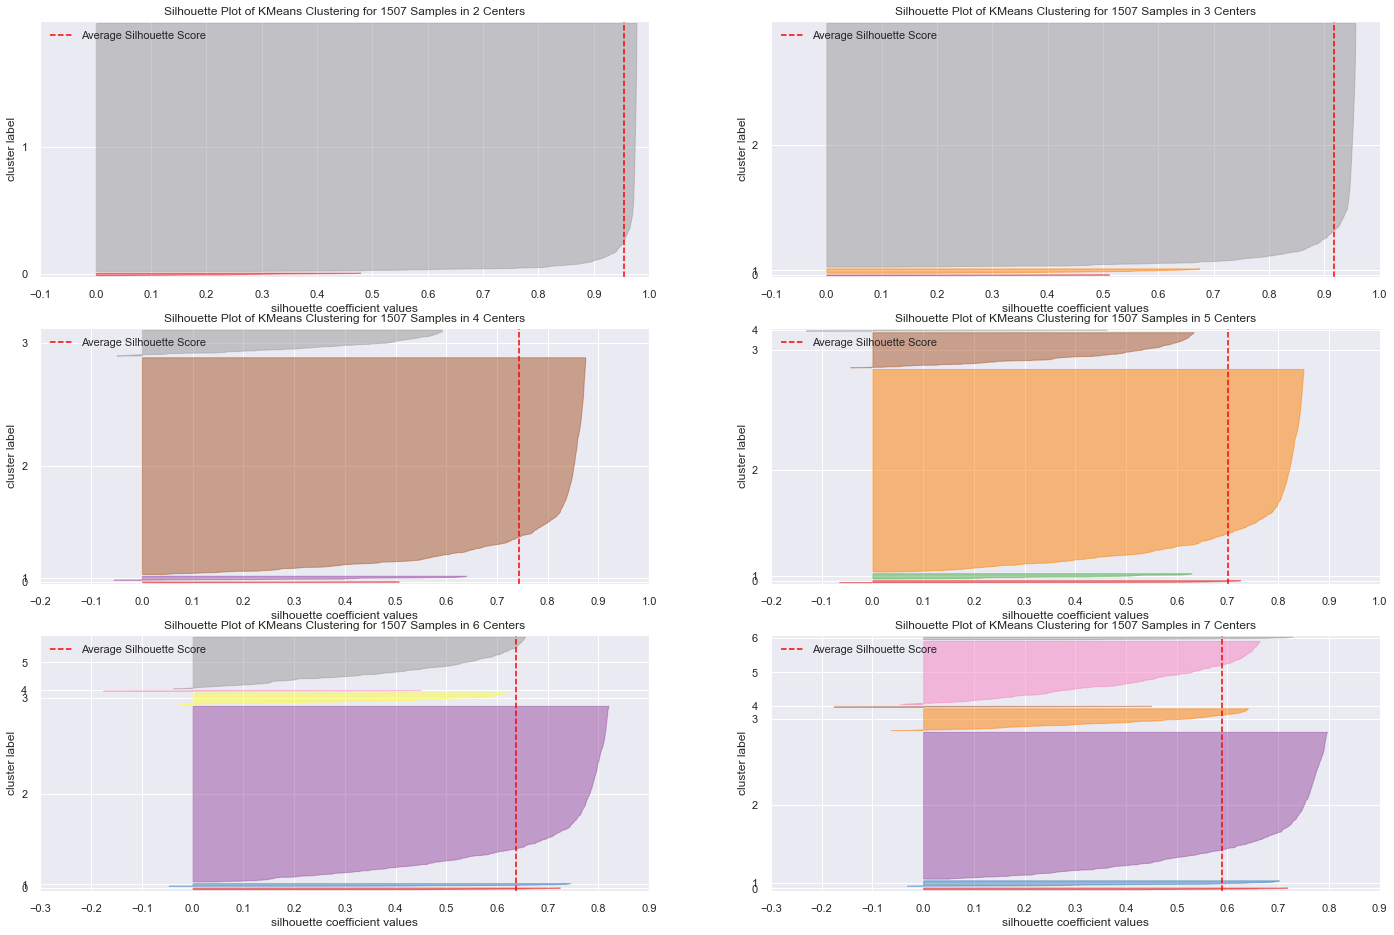

In [203]:
fig, ax = plt.subplots(3,2,figsize=(24,16))
for k in clusters:
    km = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=99)
    
    q, mod = divmod(k,2)
    
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize();

# 8.0. PASSO 08 - MODEL TRAINING

## 8.1. K-Means

In [224]:
# model definition
k = 4
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=99)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.1.1. Cluster Validation

In [225]:
# WSS 
print(f'WSS: {kmeans.inertia_:.2f}')

# SS
print(f'SS: {m.silhouette_score(X, labels, metric="euclidean"):.3f}')

WSS: 30172065999.26
SS: 0.744


# 9.0. PASSO 09 - CLUSTER ANALYSIS

In [226]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customerid,revenue,recency,frequency,returns,avg_ticket,cluster
0,17850,5288.63,372,34,1,155.547941,2
1,13047,3089.10,56,9,7,343.233333,2
2,12583,6629.34,2,15,2,441.956000,3
3,15100,635.10,333,3,3,211.700000,2
4,15291,4551.51,25,14,5,325.107857,2


## 9.1. Visualization Inspection

In [227]:
# fig = px.scatter_3d(df9, x='recency', y='frequency', z='revenue', color='cluster')
# fig.show()

C:\Users\Miguel\anaconda3\envs\pa005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


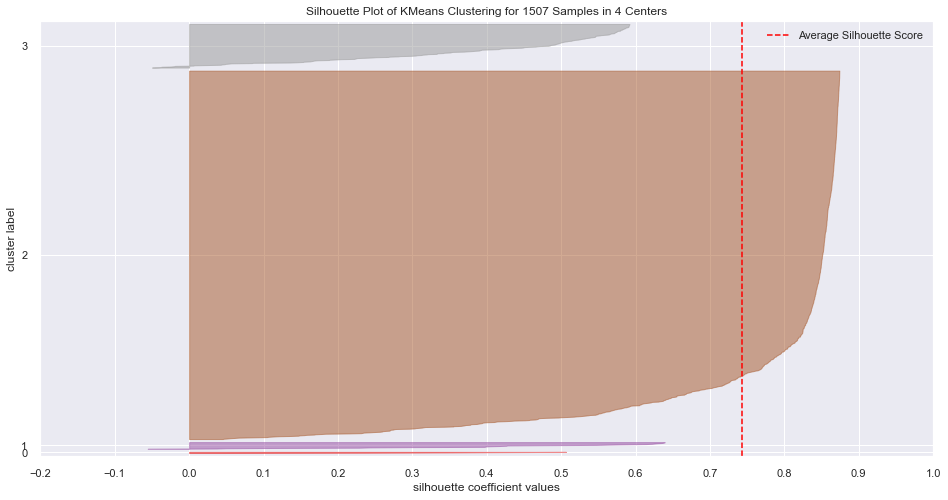

In [228]:
visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick')
visualizer.fit(X)
visualizer.finalize();

## 9.1.1. 2d plot

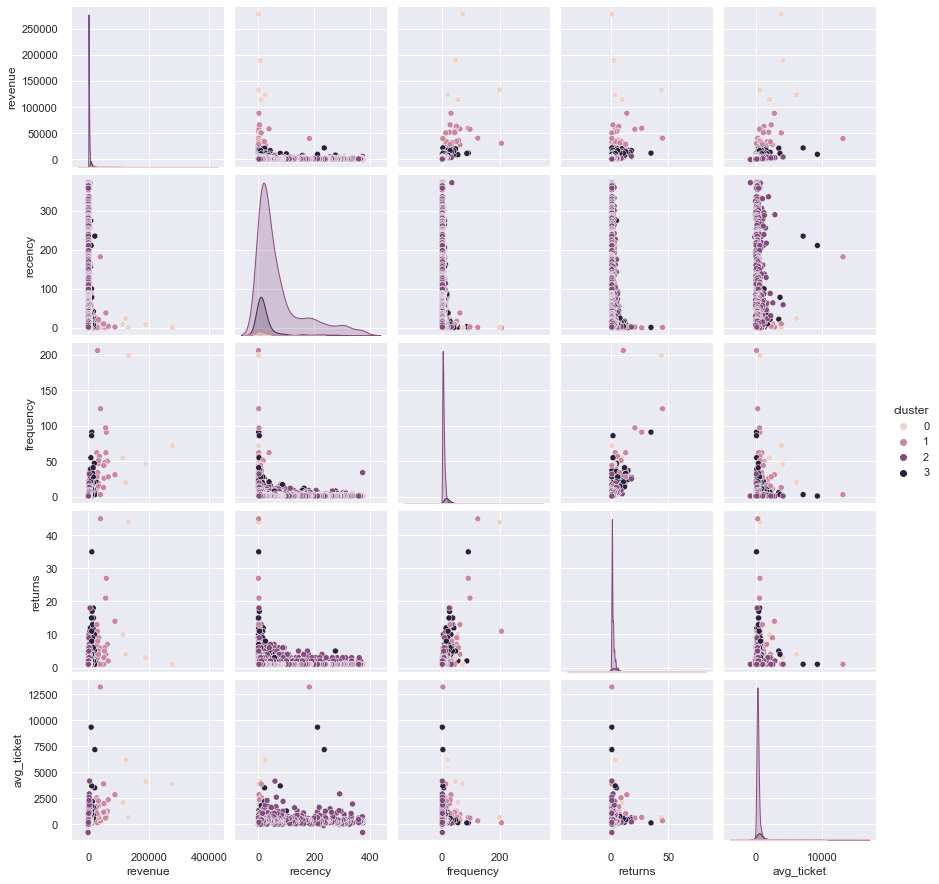

In [229]:
df_viz = df9.drop(columns=['customerid'])
sns.pairplot(df_viz, hue='cluster');

## 9.1.2. Machine Learning - Manifold

- Redução de dimensionalidade
1. PCA - Matrix, Espaço de Distância - Espaço de Hilbert - 9 Condições - Colorários

2. UMAP, t-SNE (2009) - Manifold - Topologia

In [230]:
import umap.umap_ as ump

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

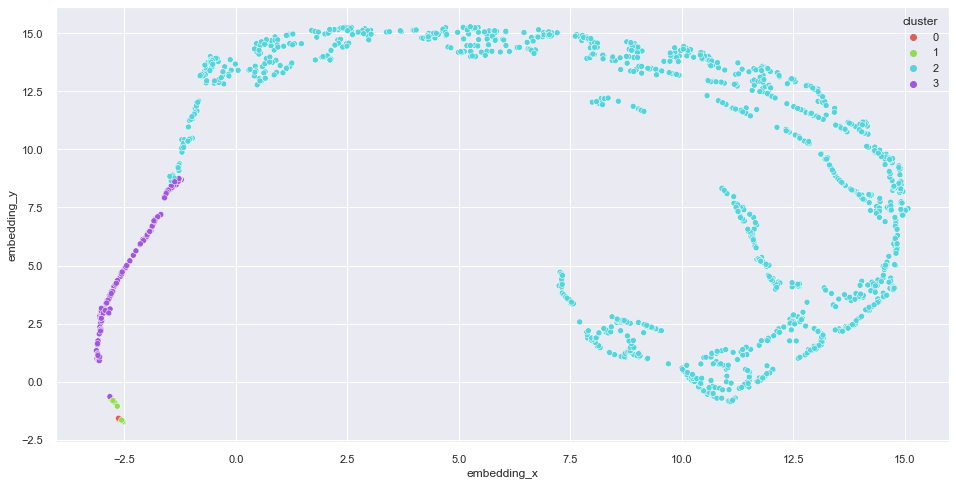

In [231]:
# projeção do X em outro espaço
reducer = ump.UMAP(random_state=99,n_neighbors=20 ) # n_neighbors --> como se representasse um zoom (olhando globalmente)
embedding = reducer.fit_transform(X)

# embedding 
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(data=df_viz, x='embedding_x', y='embedding_y', hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())))

# pontos proximos da mesma cor --> na alta dimensionalidade a probabilidade de estarem proximos é alta

## 9.2. Cluster Profile

In [222]:
# Number of customers
df_profile = pd.DataFrame({'count': df9['cluster'].value_counts(), 
                                    'percent': df9['cluster'].value_counts(normalize=True) * 100})

df_profile.index.name = 'cluster'

df_profile = df_profile.reset_index()

# Average in other metrics
average_metrics_by_cluster = df9.drop(columns=['customerid']).groupby('cluster').mean().reset_index()


df_profile = df_profile.merge(average_metrics_by_cluster, on='cluster').sort_values('revenue', ascending=False)
df_profile

,cluster,count,percent,revenue,recency,frequency,returns,avg_ticket
5,4,5,0.331785,167932.836000,8.600000,78.400000,12.400000,3385.760765
4,0,11,0.729927,59322.656364,7.090909,48.545455,8.272727,1636.916385
3,1,17,1.128069,30993.354706,30.411765,43.764706,8.529412,2220.006999
2,3,73,4.844061,12377.508767,14.424658,21.780822,5.616438,897.509684
1,5,318,21.101526,4658.367642,28.336478,11.657233,2.924528,531.717269
0,2,1083,71.864632,1126.478643,80.531856,3.936288,1.583564,319.755369


In [232]:
for _,linha in df_profile.iterrows():
    print(f"Cluster {linha['cluster']+1:.0f}")
    print(f"Número de clientes: {linha['count']:.0f} ({linha['percent']:.2f}% da base)")
    print(f"Recência em média: {linha['recency']:.2f} dias")
    print(f"Frequência média: {linha['frequency']:.2f} compras")
    print(f"Receita em média: U$ {linha['revenue']:,.2f}")
    print(f"AVG Ticket: U$ {linha['avg_ticket']:,.2f}/compra")
    print('\n')

Cluster 5
Número de clientes: 5 (0.33% da base)
Recência em média: 8.60 dias
Frequência média: 78.40 compras
Receita em média: U$ 167,932.84
AVG Ticket: U$ 3,385.76/compra


Cluster 1
Número de clientes: 11 (0.73% da base)
Recência em média: 7.09 dias
Frequência média: 48.55 compras
Receita em média: U$ 59,322.66
AVG Ticket: U$ 1,636.92/compra


Cluster 2
Número de clientes: 17 (1.13% da base)
Recência em média: 30.41 dias
Frequência média: 43.76 compras
Receita em média: U$ 30,993.35
AVG Ticket: U$ 2,220.01/compra


Cluster 4
Número de clientes: 73 (4.84% da base)
Recência em média: 14.42 dias
Frequência média: 21.78 compras
Receita em média: U$ 12,377.51
AVG Ticket: U$ 897.51/compra


Cluster 6
Número de clientes: 318 (21.10% da base)
Recência em média: 28.34 dias
Frequência média: 11.66 compras
Receita em média: U$ 4,658.37
AVG Ticket: U$ 531.72/compra


Cluster 3
Número de clientes: 1083 (71.86% da base)
Recência em média: 80.53 dias
Frequência média: 3.94 compras
Receita em média:

# 10.0. PASSO 10 - DEPLOY TO PRODUCTION